In [17]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

#生成数据集
max_degree=20 #多项式的最大阶数，即最高次项为 x^19
n_train,n_test=100,100
true_w=np.zeros(max_degree) #表示多项式的权重
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
#np.power(x1,x2),求X1的X2次方，其中x1与x2形状相同或可广播，构成对应位置的底数和指数
#np.power(features,[0,1,2,……19])
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1) #gamma(n + 1)=n!
labels=np.dot(poly_features,true_w) #计算多项式特征与真实权重的点积，得到无噪声的标签值
labels+=np.random.normal(scale=0.1,size=labels.shape)#loc scale size:均值，方差，形状

In [ ]:
#features为200×1,指数数组为1×20，广播机制，故得到poly_features为200×20
features.shape,poly_features.shape

((200, 1), (200, 20))

In [18]:
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]
features[:2]#查看features[0],features[1]

tensor([[-0.8658],
        [ 0.3406]])

In [12]:
#评估损失的函数
def evaluate_loss(net,data_iter,loss):
    metric =d2l.Accumulator(2)
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [13]:
#训练函数
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    loss=nn.MSELoss(reduction='none')
    input_shape=train_features.shape[-1] #获取训练特征的最后一个维度的大小，即特征的数量
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))#输入特征数量为input_shape，输出为1,且不设偏置项
    batch_size=min(10,train_labels.shape[0])#确保确保批量大小不会超过样本数量
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
    trainer=torch.optim.SGD(net.parameters(),lr=0.01)
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
                          xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())



weight: [[ 4.991798   1.2219616 -3.3754003  5.525612 ]]


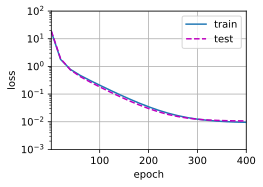

In [6]:
#三阶多项式函数拟合
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

weight: [[3.5863159 3.661937 ]]


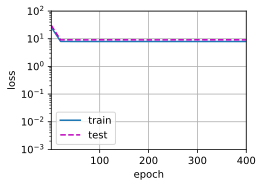

In [14]:
#线性函数拟合（发生欠拟合）
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

weight: [[ 5.00337601e+00  1.28049862e+00 -3.39421821e+00  5.19964266e+00
   2.09026709e-02  1.15815878e+00  6.44976348e-02  1.70551538e-01
  -1.76264763e-01 -1.37967383e-02  1.90663293e-01  2.03587577e-01
  -2.12769717e-01  2.86474213e-04 -1.70607807e-03 -1.36006087e-01
   1.08929604e-01  1.09611064e-01  1.87968493e-01 -1.18040852e-01]]


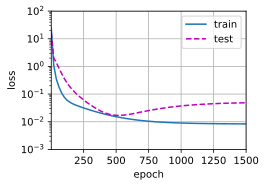

In [20]:
#高阶多项式，会出现过拟合
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:],1500)